In [27]:
# Import bibliotheque
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Model and performance
import xgboost as xgb
from sklearn. ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
#from sklearn import metric

import warnings
warnings.filterwarnings("ignore")

# Feature Selection
from sklearn. feature_selection import RFE

import joblib

In [28]:
# Data path

train_feature_down_path = '../preprocessing/Output/train_feature_down.csv'
train_labels_down_path  = '../preprocessing/Output/train_labels_down.csv'

feature_file_path = '../preprocessing/Output/train_feature.csv'
val_feature_path  = '../preprocessing/Output/val_feature.csv'
val_labels_path   = '../preprocessing/Output/val_labels.csv'
test_feature_path  = '../preprocessing/Output/test_feature.csv'
test_labels_path   = '../preprocessing/Output/test_labels.csv'

# Chargement des données d'entraînement et de test dans des DataFrames pandas
train_feature_down = pd.read_csv(train_feature_down_path)
train_labels_down  = pd.read_csv(train_labels_down_path)

val_feature   = pd.read_csv(val_feature_path)
val_labels    = pd.read_csv(val_labels_path)
test_feature = pd.read_csv(test_feature_path)
test_labels  = pd.read_csv(test_labels_path)

### Modele XGBoost

In [29]:
 #GridSearchCV
seed = 42 
param_grid = {'max_depth': [3,4,5,6, 7, 8, 9, 10], 
              'n_estimators': [2,3,4,5,6,7,8,9,10], 
              'learning_rate': [0.1, 0.01, 0.2, 0.3, 0.4,0.5, 0.6] }

# XGBoost Classifier
clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state = seed, n_jobs=-1),
                              param_grid= param_grid, 
                              scoring ='f1')
clf.fit(train_feature_down, train_labels_down)

# Prediction
y_pred = clf.predict(val_feature)

# extraction des TN, FP, FN, TP
TN, FP, FN, TP = confusion_matrix(val_labels, y_pred).ravel()
  
# Metrics
accuracy  = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred)
recall    = recall_score(val_labels, y_pred)
f1        = f1_score(val_labels, y_pred)
Sensibility = TP /(TP + FN)
Specificity = TN / (TN + FP)

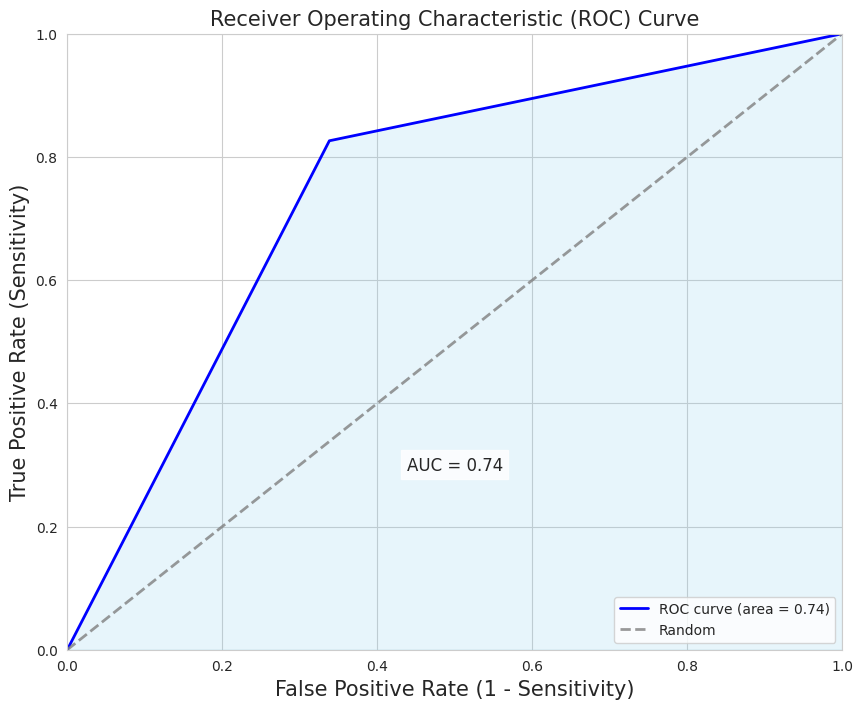

accuracy: 0.705547652916074 

precision: 0.4696048632218845 

recall: 0.8262032085561497 

f1: 0.5988372093023255 
 Class_Value 
 Churn
0        1032
1         374
dtype: int64 

Sensibility: 0.8262032085561497 

Specificity: 0.6618217054263565 

confusion_matrix:
 [[683 349]
 [ 65 309]] 



In [30]:
# Courbe ROC et AUC de la méthode ROS
fpr, tpr, thresholds = roc_curve(val_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Personnalisation de la courbe ROC
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc), color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random', alpha=0.8)
plt.text(0.5, 0.3, 'AUC = {:.2f}'.format(roc_auc), ha='center', va='center', size=12, bbox=dict(facecolor='white', alpha=0.8))


# Ajout de couleurs et de légendes
plt.fill_between(fpr, tpr, 0, color='skyblue', alpha=0.2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (1 - Sensitivity)', size=15)
plt.ylabel('True Positive Rate (Sensitivity)', size=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# AUC
roc_auc_score(val_labels, y_pred)

# Affichage des metrics de la methode ros
print('accuracy:', metrics.accuracy_score(val_labels, y_pred), '\n')
print('precision:', metrics.precision_score(val_labels, y_pred), '\n')
print('recall:', metrics.recall_score(val_labels, y_pred), '\n')
print('f1:', metrics.f1_score(val_labels, y_pred),'\n','Class_Value','\n', val_labels.value_counts(), '\n')
print('Sensibility:', Sensibility, '\n')
print('Specificity:', Specificity, '\n')
print('confusion_matrix:\n',confusion_matrix(val_labels, y_pred),'\n')

### Modele de foret aleatoire

In [31]:
# Slection des meilleurs variables predictrices
rf = RandomForestClassifier()
rf.fit(train_feature_down, train_labels_down)

y_pred = rf.predict(val_feature)

auc_score = roc_auc_score(val_labels, y_pred)

# Rapport de classification
print(classification_report(val_labels, y_pred), "\n")
print("AUC Score:", auc_score)

              precision    recall  f1-score   support

           0       0.89      0.69      0.77      1032
           1       0.47      0.76      0.58       374

    accuracy                           0.71      1406
   macro avg       0.68      0.72      0.68      1406
weighted avg       0.78      0.71      0.72      1406
 

AUC Score: 0.7235548024706712


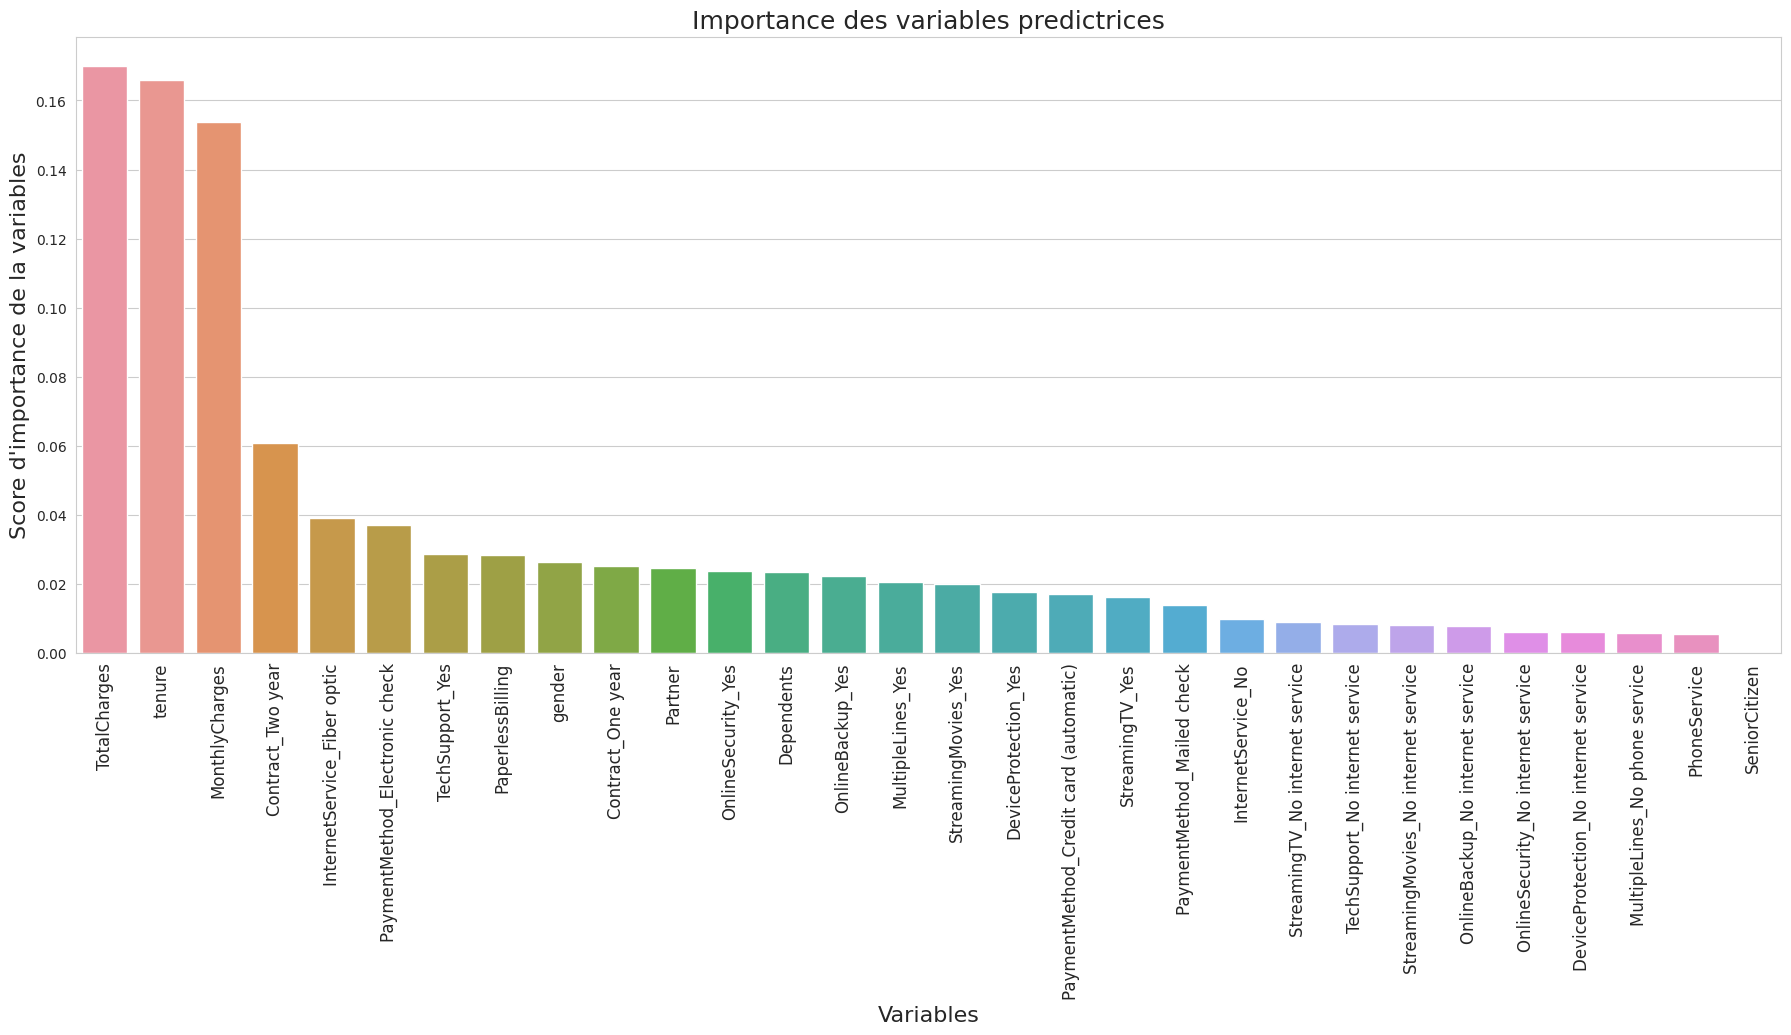

In [32]:
# Importance des variables indépendantes
feature_imp = pd.Series(rf.feature_importances_, index = train_feature_down.columns).sort_values(ascending = False)

# Graphique de l'importance des variables predictrices
plt.figure(figsize=(22,8))
sns.barplot(x = feature_imp.index, y = feature_imp)
plt.xticks(rotation=90, fontsize = 12)
plt.xlabel("Variables", fontsize = 16)
plt.ylabel("Score d'importance de la variables", fontsize = 16)
plt.title("Importance des variables predictrices", size = 18)
plt.show()

In [33]:
# Variables selectionnées pour les algorithmes
seuil = 0.004
vars_select = feature_imp[feature_imp > seuil].index.to_list()

In [34]:
# Nombre de variables predictrices
print('Nombres de variables selectionnées :', len(vars_select))

Nombres de variables selectionnées : 29


### Modele de regression logistique

In [35]:
# Dictionnaire des hyper_parametres
param_grid = {'C' :[0.001, 0.01, 1, 10, 50, 100, 500]}
seed = 42

# Objet GridSearchCV
grid_logreg = GridSearchCV(estimator=LogisticRegression(random_state = seed, max_iter = 500),
                                 param_grid = param_grid,
                                 scoring = 'f1',
                                 cv = 5)

# Entrainement de l'algorithme
logreg_model = grid_logreg.fit(train_feature_down, train_labels_down)

# Meilleurs score et meilleurs hyper_parametre
print(round(logreg_model.best_score_, 3))

print(logreg_model.best_estimator_)

0.769
LogisticRegression(C=0.001, max_iter=500, random_state=42)


In [36]:
# Fonction d'évaluation performance d'un modèle
def model_evaluation(model, feature, labels):
    y_pred = model.predict(feature)
    auc_score = roc_auc_score(labels, y_pred)
    
    print("Classification Report:")
    print(classification_report(labels, y_pred))
    
    print("\nAUC Score:", auc_score)

In [37]:
# Evaluation du modèle de Regression logistique
model_evaluation(logreg_model.best_estimator_, val_feature, val_labels)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1032
           1       0.45      0.82      0.58       374

    accuracy                           0.69      1406
   macro avg       0.68      0.73      0.67      1406
weighted avg       0.78      0.69      0.71      1406


AUC Score: 0.7280059486796834


### Modele de foret aleatoire

In [38]:
# Dictionnaire des hyper_parametres
param_grid_rf = {'n_estimators' :[10, 50, 100, 500, 1000], 'max_depth' :[3, 5, 100, 500]}

# Objet GridSearchCV
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state = seed),
                                 param_grid = param_grid_rf,
                                 scoring = 'f1',
                                 cv = 5)

# Entrainement de l'algorithme
rf_model = grid_rf.fit(train_feature_down, train_labels_down)

# Meilleurs score et meilleurs hyper_parametre
print(round(rf_model.best_score_, 3))

print(rf_model.best_estimator_)

0.78
RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=42)


In [39]:
# Evaluation du modèle de Forêt aléatoire
model_evaluation(rf_model.best_estimator_, val_feature, val_labels)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1032
           1       0.47      0.76      0.58       374

    accuracy                           0.71      1406
   macro avg       0.68      0.73      0.68      1406
weighted avg       0.78      0.71      0.73      1406


AUC Score: 0.7262104630435684


### Sauvegarde du meilleur modele (XGboost)

In [40]:
# Exportez le modèle
joblib.dump(clf, 'Output/xgboost_model.joblib')
joblib.dump(grid_logreg, 'Output/logreg_model.joblib')
joblib.dump(rf_model, 'Output/rf_model.joblib')

['Output/rf_model.joblib']

In [41]:
# Charger le modèle
model = joblib.load('Output/xgboost_model.joblib')

# Étape 2 : Faire des prédictions sur les données de test
test_predictions = model.predict(test_feature)

# Étape 3 : Évaluer les performances du modèle
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Afficher les résultats
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.7100213219616205
Precision: 0.4755747126436782
Recall: 0.8850267379679144
F1 Score: 0.6186915887850467
Confusion Matrix:
 [[668 365]
 [ 43 331]]


In [42]:
# Charger le modèle
model = joblib.load('Output/logreg_model.joblib')

# Étape 2 : Faire des prédictions sur les données de test
test_predictions = model.predict(test_feature)

# Étape 3 : Évaluer les performances du modèle
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Afficher les résultats
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.7014925373134329
Precision: 0.46546546546546547
Recall: 0.8288770053475936
F1 Score: 0.5961538461538461
Confusion Matrix:
 [[677 356]
 [ 64 310]]


In [43]:
# Charger le modèle
model = joblib.load('Output/rf_model.joblib')

# Étape 2 : Faire des prédictions sur les données de test
test_predictions = model.predict(test_feature)

# Étape 3 : Évaluer les performances du modèle
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Afficher les résultats
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.7192608386638237
Precision: 0.48346456692913387
Recall: 0.820855614973262
F1 Score: 0.6085232903865213
Confusion Matrix:
 [[705 328]
 [ 67 307]]
